## Overview

The purpose of this kernel is to take a look at the data, come up with some insights, and attempt to create a predictive model or two. This notebook is still **very** raw. I will work on it as my very limited time permits, and hope to expend it in the upcoming days and weeks.

NB: Most of the feature engineering and some of the modeling is based on [Peter Hurford's excellent kernel](https://www.kaggle.com/peterhurford/you-re-going-to-want-more-categories-lb-3-737/notebook) , and [another one by Konrad Banachevitz.](https://www.kaggle.com/konradb/lgb-fe-lb-3-707)

## Imports

In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [2]:
from fastai import *
from fastai.vision import *
from fastai.tabular import *
from fastai.basics import *

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import preprocessing
from sklearn.linear_model import Ridge
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import mean_squared_error

import lightgbm as lgb
import xgboost as xgb

import datetime
import warnings
warnings.filterwarnings("ignore")

In [4]:
plt.style.use(['dark_background'])

In [5]:
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2    
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

## Paths

In [6]:
PATH = Config.data_path()/'competitions/elo-merchant-category-recommendation/'
#table_names = list(map(lambda p:p.stem, PATH.glob("*.csv"))); table_names
PATH.ls()

[PosixPath('/home/achen/.fastai/data/competitions/elo-merchant-category-recommendation/Data_Dictionary.xlsx'),
 PosixPath('/home/achen/.fastai/data/competitions/elo-merchant-category-recommendation/historical_transactions.csv'),
 PosixPath('/home/achen/.fastai/data/competitions/elo-merchant-category-recommendation/historical_transactions.csv.zip'),
 PosixPath('/home/achen/.fastai/data/competitions/elo-merchant-category-recommendation/merchants.csv'),
 PosixPath('/home/achen/.fastai/data/competitions/elo-merchant-category-recommendation/merchants.csv.zip'),
 PosixPath('/home/achen/.fastai/data/competitions/elo-merchant-category-recommendation/new_merchant_transactions.csv'),
 PosixPath('/home/achen/.fastai/data/competitions/elo-merchant-category-recommendation/new_merchant_transactions.csv.zip'),
 PosixPath('/home/achen/.fastai/data/competitions/elo-merchant-category-recommendation/sample_submission.csv.zip'),
 PosixPath('/home/achen/.fastai/data/competitions/elo-merchant-category-recom

We see that in addition to the usual,`train`, `test` and `sample_submission` files, we also have `merchants`, `historical_transactions`, `new_merchant_transactions`, and even one (**HORROR!!!**) excel file - `Data_Dictionary`. The names of the files are pretty self-explanatory, but we'll take a look at them and explore them. First, let's look at the `train` and `test` files.

## EDA

In [7]:
train = pd.read_csv(PATH/"train.csv", parse_dates=["first_active_month"])
test  = pd.read_csv(PATH/"test.csv", parse_dates=["first_active_month"])

In [8]:
_merchant = pd.read_csv(PATH/"merchants.csv")

In [9]:
_new     = pd.read_csv(PATH/"new_merchant_transactions.csv", parse_dates=["purchase_date"]) 
_history = pd.read_csv(PATH/"historical_transactions.csv", parse_dates=["purchase_date"])

In [10]:
train.shape, test.shape

((201917, 6), (123623, 5))

In [11]:
_new.shape, _history.shape, _merchant.shape

((1963031, 14), (29112361, 14), (334696, 22))

In [12]:
train.head()

,first_active_month,card_id,feature_1,feature_2,feature_3,target
0,2017-06-01,C_ID_92a2005557,5,2,1,-0.820283
1,2017-01-01,C_ID_3d0044924f,4,1,0,0.392913
2,2016-08-01,C_ID_d639edf6cd,2,2,0,0.688056
3,2017-09-01,C_ID_186d6a6901,4,3,0,0.142495
4,2017-11-01,C_ID_cdbd2c0db2,1,3,0,-0.159749


In [13]:
test.head()

,first_active_month,card_id,feature_1,feature_2,feature_3
0,2017-04-01,C_ID_0ab67a22ab,3,3,1
1,2017-01-01,C_ID_130fd0cbdd,2,3,0
2,2017-08-01,C_ID_b709037bc5,5,1,1
3,2017-12-01,C_ID_d27d835a9f,2,1,0
4,2015-12-01,C_ID_2b5e3df5c2,5,1,1


Seems farily straightforward - just ID, first active months, three anonimous features, and target field for train set.

Let's take a look at the target variable:

In [14]:
train.target.describe()

count    201917.000000
mean         -0.393636
std           3.850500
min         -33.219281
25%          -0.883110
50%          -0.023437
75%           0.765453
max          17.965068
Name: target, dtype: float64

Seems like a very wide range of values, relatively spaking. Let's take a look at the graph of the distribution:

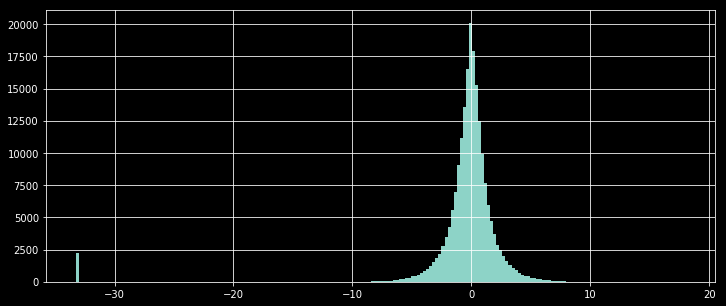

In [15]:
train.target.hist(bins=200, figsize=(12,5));
#plt.title('Histogram target counts');
#plt.xlabel('Count');
#plt.ylabel('Target');

Seems like a pretty nice normal-looking distribution, except for the few anomalous elements at the far left. They will have to be dealt with separately.

Let's now look at the distributions of various "features"

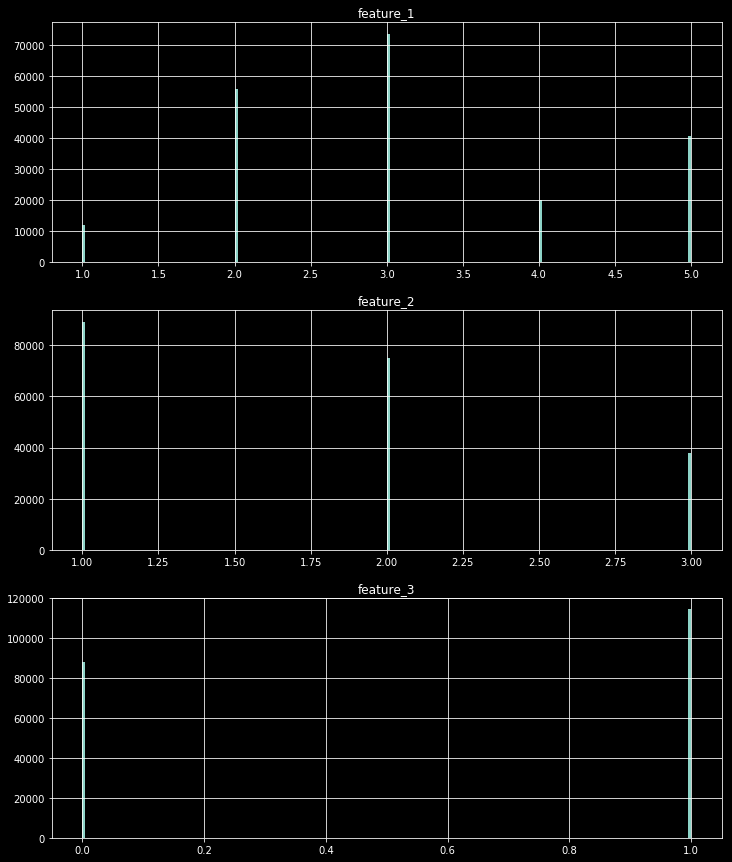

In [16]:
fig,axes = plt.subplots(3,1,figsize=(12,15))
cols = ['feature_1', 'feature_2', 'feature_3']
for ax,c in zip(axes.flatten(), cols):
    ax.set_title(c)
    train[c].hist(ax=ax, bins=200)

A couple of things that stand out are:

1. There are only a handful of values for each of the three features.
2. They are discrete
3. They are relatively eavenly distributed.

All of this suggests that these features are categorical and have been label-encoded. 

## Feature Extraction

Add time information

In [17]:
add_datepart(train, "first_active_month", drop=False)
add_datepart(test, "first_active_month", drop=False)

In [18]:
train['elapsed'] = (datetime.date(2018, 2, 1) - train.first_active_month.dt.date).dt.days
test['elapsed']  = (datetime.date(2018, 2, 1) - test.first_active_month.dt.date).dt.days

Label outliers and for level stratifying. This idea is from [this kernel](https://www.kaggle.com/chauhuynh/my-first-kernel-3-699).

In [19]:
train['outlier'] = 0
train.loc[train['target']<-30, 'outliers'] = 1

In [20]:
find_common = lambda df1,df2 : list(set(df1.columns).intersection(set(df2.columns)))

def join_df(left, right, left_on, right_on=None, suffix='_y'):
    if right_on is None: right_on = left_on
    return left.merge(right, how='left', left_on=left_on, right_on=right_on, 
                      suffixes=("", suffix))

In [22]:
find_common(train, _new), find_common(train, _history)

(['card_id'], ['card_id'])

In [ ]:
joined.to_pickle(PATH/'joined_0')
joined_test.to_pickle(PATH/'joined_test_0')

In [ ]:
joined = pd.read_pickle(PATH/'joined_0')
joined_test = pd.read_pickle(PATH/'joined_test_0')

In [ ]:
joined = join_df(joined, new, left_on='card_id')
joined_test = join_df(joined_test, new, left_on='card_id')

In [ ]:
for df in (joined, joined_test):
    for c in df.columns:
        if c.endswith('_y'):
            if c in df.columns: df.drop(c, inplace=True, axis=1)

Lets join more tables later
- [ ] history - authorized
- [ ] history - unauthorized
- [ ] final_group
- [ ] auth_mean

## EON 

In [23]:
def binarize(df):
    for col in ['authorized_flag', 'category_1']:
        df[col] = df[col].map({'Y':1, 'N':0})
    return df

In [24]:
_history = binarize(_history)
_new     = binarize(_new)

In [25]:
_history = pd.get_dummies(_history, columns=['category_2', 'category_3'])
_new     = pd.get_dummies(_new,     columns=['category_2', 'category_3'])

In [26]:
_history = reduce_mem_usage(_history)
_new     = reduce_mem_usage(_new)

Mem. usage decreased to 1304.89 Mb (54.8% reduction)
Mem. usage decreased to 84.24 Mb (56.7% reduction)


In [27]:
agg_func = {'authorized_flag' : ['sum', 'mean']}
auth_mean = _history.groupby(['card_id']).agg(agg_func)

In [28]:
# Convert multi-index label to single-index label
auth_mean.columns = ['_'.join(col).strip() for col in auth_mean.columns.values]
auth_mean.reset_index(inplace=True)

In [33]:
_auth   = _history[_history['authorized_flag'] == 1]
_unauth = _history[_history['authorized_flag'] == 0]

In [34]:
_unauth['purchase_month'] = _unauth['purchase_date'].dt.month
_auth['purchase_month']   = _auth['purchase_date'].dt.month
_new['purchase_month']    = _new['purchase_date'].dt.month

In [35]:
def aggregate_transactions(history):
    
    history.loc[:, 'purchase_date'] = pd.DatetimeIndex(history['purchase_date']).\
                                      astype(np.int64) * 1e-9
    
    agg_func = {
        'category_1': ['sum', 'mean'],
        'category_2_1.0': ['mean'],
        'category_2_2.0': ['mean'],
        'category_2_3.0': ['mean'],
        'category_2_4.0': ['mean'],
        'category_2_5.0': ['mean'],
        'category_3_A': ['mean'],
        'category_3_B': ['mean'],
        'category_3_C': ['mean'],
        'merchant_id': ['nunique'],
        'merchant_category_id': ['nunique'],
        'state_id': ['nunique'],
        'city_id': ['nunique'],
        'subsector_id': ['nunique'],
        'purchase_amount': ['sum', 'mean', 'max', 'min', 'std'],
        'installments': ['sum', 'mean', 'max', 'min', 'std'],
        'purchase_month': ['mean', 'max', 'min', 'std'],
        'purchase_date': [np.ptp, 'min', 'max'],
        'month_lag': ['min', 'max']
        }
    
    agg_history = history.groupby(['card_id']).agg(agg_func)
    agg_history.columns = ['_'.join(col).strip() for col in agg_history.columns.values]
    agg_history.reset_index(inplace=True)
    
    df = (history.groupby('card_id')
          .size()
          .reset_index(name='transactions_count'))
    
    agg_history = pd.merge(df, agg_history, on='card_id', how='left')
    
    return agg_history


In [36]:
unauth = aggregate_transactions(_unauth)
unauth.columns = ['unauth_' + c if c != 'card_id' else c for c in unauth.columns]
unauth[:5]

,card_id,unauth_transactions_count,unauth_category_1_sum,unauth_category_1_mean,unauth_category_2_1.0_mean,unauth_category_2_2.0_mean,unauth_category_2_3.0_mean,unauth_category_2_4.0_mean,unauth_category_2_5.0_mean,unauth_category_3_A_mean,...,unauth_installments_std,unauth_purchase_month_mean,unauth_purchase_month_max,unauth_purchase_month_min,unauth_purchase_month_std,unauth_purchase_date_ptp,unauth_purchase_date_min,unauth_purchase_date_max,unauth_month_lag_min,unauth_month_lag_max
0,C_ID_00007093c1,35,4.0,0.114286,0.000000,0.000000,0.885714,0.0,0.000000,0.000000,...,0.667367,5.914286,12,1,3.071419,28858113.0,1.489250e+09,1.518108e+09,-11,0
1,C_ID_0001238066,3,0.0,0.000000,0.333333,0.000000,0.000000,0.0,0.666667,0.000000,...,0.000000,8.666667,12,2,5.773503,3609150.0,1.514660e+09,1.518269e+09,-2,0
2,C_ID_0001506ef0,4,0.0,0.000000,0.000000,0.000000,1.000000,0.0,0.000000,0.750000,...,0.500000,5.500000,12,2,4.725816,22098875.0,1.496772e+09,1.518871e+09,-8,0
3,C_ID_0001793786,27,2.0,0.074074,0.111111,0.296296,0.111111,0.0,0.000000,0.814815,...,0.395847,6.481481,9,3,2.375684,16780236.0,1.488636e+09,1.505416e+09,-7,-1
4,C_ID_000183fdda,7,0.0,0.000000,0.000000,0.000000,1.000000,0.0,0.000000,0.000000,...,2.288689,8.285714,10,8,0.755929,6701589.0,1.502099e+09,1.508801e+09,-6,-4


In [37]:
auth = aggregate_transactions(_auth)
auth.columns = ['auth_' + c if c != 'card_id' else c for c in auth.columns]
auth[:5]

,card_id,auth_transactions_count,auth_category_1_sum,auth_category_1_mean,auth_category_2_1.0_mean,auth_category_2_2.0_mean,auth_category_2_3.0_mean,auth_category_2_4.0_mean,auth_category_2_5.0_mean,auth_category_3_A_mean,...,auth_installments_std,auth_purchase_month_mean,auth_purchase_month_max,auth_purchase_month_min,auth_purchase_month_std,auth_purchase_date_ptp,auth_purchase_date_min,auth_purchase_date_max,auth_month_lag_min,auth_month_lag_max
0,C_ID_00007093c1,114,24.0,0.210526,0.000000,0.000000,0.780702,0.0,0.008772,0.0,...,0.795159,6.517544,12,1,3.371490,32627654.0,1.487081e+09,1.519708e+09,-12,0
1,C_ID_0001238066,120,2.0,0.016667,0.783333,0.000000,0.000000,0.0,0.150000,0.0,...,1.501050,7.275000,12,1,4.895483,13110825.0,1.506638e+09,1.519748e+09,-5,0
2,C_ID_0001506ef0,62,0.0,0.000000,0.032258,0.000000,0.967742,0.0,0.000000,1.0,...,0.000000,6.887097,12,1,4.538017,34460275.0,1.484411e+09,1.518871e+09,-13,0
3,C_ID_0001793786,189,0.0,0.000000,0.042328,0.359788,0.063492,0.0,0.000000,1.0,...,0.000000,6.698413,10,1,2.301491,24487497.0,1.484994e+09,1.509481e+09,-9,0
4,C_ID_000183fdda,137,4.0,0.029197,0.051095,0.007299,0.905109,0.0,0.007299,0.0,...,2.108912,6.810219,12,1,4.538289,15148616.0,1.504444e+09,1.519592e+09,-5,0


In [38]:
new = aggregate_transactions(_new)
new.columns = ['new_' + c if c != 'card_id' else c for c in new.columns]
new[:5]

,card_id,new_transactions_count,new_category_1_sum,new_category_1_mean,new_category_2_1.0_mean,new_category_2_2.0_mean,new_category_2_3.0_mean,new_category_2_4.0_mean,new_category_2_5.0_mean,new_category_3_A_mean,...,new_installments_std,new_purchase_month_mean,new_purchase_month_max,new_purchase_month_min,new_purchase_month_std,new_purchase_date_ptp,new_purchase_date_min,new_purchase_date_max,new_month_lag_min,new_month_lag_max
0,C_ID_00007093c1,2,0,0.000000,0.500000,0.000000,0.50000,0.0,0.000000,0.0,...,0.000000,4.000000,4,4,0.000000,537024.0,1.522754e+09,1.523291e+09,2,2
1,C_ID_0001238066,26,2,0.076923,0.769231,0.000000,0.00000,0.0,0.115385,0.0,...,2.079941,3.346154,4,3,0.485165,5195343.0,1.519923e+09,1.525118e+09,1,2
2,C_ID_0001506ef0,2,0,0.000000,0.000000,0.000000,1.00000,0.0,0.000000,1.0,...,0.000000,3.000000,3,3,0.000000,471152.0,1.521239e+09,1.521710e+09,1,1
3,C_ID_0001793786,31,0,0.000000,0.483871,0.258065,0.16129,0.0,0.032258,1.0,...,0.000000,11.322581,12,11,0.475191,3981096.0,1.510761e+09,1.514742e+09,1,2
4,C_ID_000183fdda,11,0,0.000000,0.000000,0.000000,1.00000,0.0,0.000000,0.0,...,1.293340,3.272727,4,3,0.467099,5106807.0,1.519994e+09,1.525100e+09,1,2


In [39]:
def aggregate_per_month(history):
    grouped = history.groupby(['card_id', 'month_lag'])

    agg_func = {
            'purchase_amount': ['count', 'sum', 'mean', 'min', 'max', 'std'],
            'installments': ['count', 'sum', 'mean', 'min', 'max', 'std'],
            }

    intermediate_group = grouped.agg(agg_func)
    intermediate_group.columns = ['_'.join(col).strip() for col in intermediate_group.columns.values]
    intermediate_group.reset_index(inplace=True)

    final_group = intermediate_group.groupby('card_id').agg(['mean', 'std'])
    final_group.columns = ['_'.join(col).strip() for col in final_group.columns.values]
    final_group.reset_index(inplace=True)
    
    return final_group

In [40]:
final_group =  aggregate_per_month(_unauth)
final_group[:10]

,card_id,month_lag_mean,month_lag_std,purchase_amount_count_mean,purchase_amount_count_std,purchase_amount_sum_mean,purchase_amount_sum_std,purchase_amount_mean_mean,purchase_amount_mean_std,purchase_amount_min_mean,...,installments_sum_mean,installments_sum_std,installments_mean_mean,installments_mean_std,installments_min_mean,installments_min_std,installments_max_mean,installments_max_std,installments_std_mean,installments_std_std
0,C_ID_00007093c1,-5.500000,3.605551,2.916667,1.621354,-1.200164,0.999049,-0.431906,0.260478,-0.613764,...,3.750000,3.107908,1.176389,0.326634,1.000000,0.000000,1.500000,0.797724,0.355262,0.480551
1,C_ID_0001238066,-1.000000,1.414214,1.500000,0.707107,-0.894964,0.421890,-0.596643,0.000000,-0.596643,...,1.500000,0.707107,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,NaN
2,C_ID_0001506ef0,-3.333333,4.163332,1.333333,0.577350,-0.968594,0.395645,-0.731020,0.015849,-0.732397,...,0.333333,0.577350,0.166667,0.288675,0.000000,0.000000,0.333333,0.577350,0.707107,NaN
3,C_ID_0001793786,-3.833333,2.316607,4.500000,1.974842,-1.970890,2.037261,-0.423501,0.392159,-0.676499,...,0.833333,0.983192,0.291667,0.400520,0.166667,0.408248,0.500000,0.547723,0.179558,0.279244
4,C_ID_000183fdda,-5.000000,1.414214,3.500000,3.535534,-0.470690,0.344856,-0.376174,0.478523,-0.579708,...,9.500000,12.020815,2.000000,1.414214,1.000000,0.000000,3.500000,3.535534,2.366432,NaN
5,C_ID_00024e244b,-5.000000,4.000000,2.428571,1.397276,-1.186659,1.210810,-0.558085,0.326273,-0.607249,...,0.714286,1.112697,0.297619,0.419041,0.142857,0.377964,0.428571,0.534522,0.269338,0.312603
6,C_ID_0002709b5a,-7.250000,5.057997,1.500000,1.000000,-0.929675,0.699316,-0.604163,0.156637,-0.616865,...,2.750000,2.362908,2.250000,2.500000,2.250000,2.500000,2.250000,2.500000,0.000000,NaN
7,C_ID_00027503e2,-4.000000,2.915476,3.600000,1.516575,-2.669652,1.128393,-0.741249,0.002457,-0.742989,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
8,C_ID_000298032a,-6.500000,3.535534,1.000000,0.000000,-0.617958,0.093896,-0.617958,0.093896,-0.617958,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,NaN
9,C_ID_0002ba3c2e,-3.666667,3.559026,2.500000,1.516575,-1.547448,0.910264,-0.641704,0.080430,-0.655965,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [42]:
joined = join_df(train, unauth, 'card_id')
joined_test = join_df(test, unauth, 'card_id')

In [43]:
joined = join_df(joined, auth, 'card_id')
joined_test = join_df(joined_test, auth, 'card_id')

In [44]:
joined = join_df(joined, new, 'card_id')
joined_test = join_df(joined_test, new, 'card_id')

In [45]:
joined = join_df(joined, final_group, 'card_id')
joined_test = join_df(joined_test, final_group, 'card_id')

In [46]:
joined = join_df(joined, auth_mean, 'card_id')
joined_test = join_df(joined_test, auth_mean, 'card_id')

In [47]:
joined.to_pickle(PATH/'joined')
joined_test.to_pickle(PATH/'joined_test')

In [ ]:
features = [c for c in joined.columns if c not in ['card_id', 'first_active_month', 'outliers']]
categorical_feats = [c for c in features if 'feature_' in c]

In [ ]:
print(train.shape)
print(test.shape)

# Modeling

Now let's do some of what everyone is here for - modeling. We'll start with a simple Ridge regression model. 

In [ ]:
'''oof_ridge = np.zeros(train.shape[0])
predictions_ridge = np.zeros(test.shape[0])

tst_data = test.copy()
tst_data.fillna((tst_data.mean()), inplace=True)

tst_data = tst_data[features].values

folds = StratifiedKFold(n_splits=5, shuffle=True, random_state=15)

for fold_, (trn_idx, val_idx) in enumerate(folds.split(train,train['outliers'].values)):
    print("fold n°{}".format(fold_+1))
    trn_data, trn_y = train.iloc[trn_idx][features], target.iloc[trn_idx].values
    val_data, val_y = train.iloc[val_idx][features], target.iloc[val_idx].values
    
    trn_data.fillna((trn_data.mean()), inplace=True)
    val_data.fillna((val_data.mean()), inplace=True)
    
    trn_data = trn_data.values
    val_data = val_data.values

    clf = Ridge(alpha=100)
    clf.fit(trn_data, trn_y)
    
    oof_ridge[val_idx] = clf.predict(val_data)
    predictions_ridge += clf.predict(tst_data) / folds.n_splits

np.save('oof_ridge', oof_ridge)
np.save('predictions_ridge', predictions_ridge)
np.sqrt(mean_squared_error(target.values, oof_ridge))'''

In [ ]:
'''del tst_data
gc.collect()'''

3.78 CV is not bad, but it's far from what the best models can do in this competition. Let's take a look at a few non-linear models. We'll start with LightGBM.

In [ ]:
'''param = {'num_leaves': 120,
         'min_data_in_leaf': 30, 
         'objective':'regression',
         'max_depth': -1,
         'learning_rate': 0.005,
         "min_child_samples": 30,
         "boosting": "gbdt",
         "feature_fraction": 0.9,
         "bagging_freq": 1,
         "bagging_fraction": 0.9 ,
         "bagging_seed": 11,
         "metric": 'rmse',
         "lambda_l1": 0.1,
         "verbosity": -1}

oof_lgb = np.zeros(len(train))
predictions_lgb = np.zeros(len(test))

folds = StratifiedKFold(n_splits=5, shuffle=True, random_state=15)

for fold_, (trn_idx, val_idx) in enumerate(folds.split(train,train['outliers'].values)):    
    print('-')
    print("Fold {}".format(fold_ + 1))
    trn_data = lgb.Dataset(train.iloc[trn_idx][features], label=target.iloc[trn_idx])
    val_data = lgb.Dataset(train.iloc[val_idx][features], label=target.iloc[val_idx])

    num_round = 10000
    clf = lgb.train(param, trn_data, num_round, valid_sets = [trn_data, val_data], verbose_eval=100, early_stopping_rounds=200)
    oof_lgb[val_idx] = clf.predict(train.iloc[val_idx][features], num_iteration=clf.best_iteration)
    predictions_lgb += clf.predict(test[features], num_iteration=clf.best_iteration) / folds.n_splits
    
np.save('oof_lgb', oof_lgb)
np.save('predictions_lgb', predictions_lgb)
np.sqrt(mean_squared_error(target.values, oof_lgb))'''

Now some XGBoost:

In [ ]:
'''xgb_params = {'eta': 0.005, 'max_depth': 10, 'subsample': 0.8, 'colsample_bytree': 0.8, 
          'objective': 'reg:linear', 'eval_metric': 'rmse', 'silent': True}

oof_xgb = np.zeros(len(train))
predictions_xgb = np.zeros(len(test))

folds = StratifiedKFold(n_splits=5, shuffle=True, random_state=15)

for fold_, (trn_idx, val_idx) in enumerate(folds.split(train,train['outliers'].values)):
    print('-')
    print("Fold {}".format(fold_ + 1))
    trn_data = xgb.DMatrix(data=train.iloc[trn_idx][features], label=target.iloc[trn_idx])
    val_data = xgb.DMatrix(data=train.iloc[val_idx][features], label=target.iloc[val_idx])
    watchlist = [(trn_data, 'train'), (val_data, 'valid')]
    print("xgb " + str(fold_) + "-" * 50)
    num_round = 10000
    xgb_model = xgb.train(xgb_params, trn_data, num_round, watchlist, early_stopping_rounds=50, verbose_eval=1000)
    oof_xgb[val_idx] = xgb_model.predict(xgb.DMatrix(train.iloc[val_idx][features]), ntree_limit=xgb_model.best_ntree_limit+50)

    predictions_xgb += xgb_model.predict(xgb.DMatrix(test[features]), ntree_limit=xgb_model.best_ntree_limit+50) / folds.n_splits
    
np.save('oof_xgb', oof_xgb)
np.save('predictions_xgb', predictions_xgb)
np.sqrt(mean_squared_error(target.values, oof_xgb))'''

# Second Set of Features and Models

A great thing about stackign is that you can not only use different set of models, but also create the same models with a different set of features. Here we'll use features from the wonderful [Elo world kernel](https://www.kaggle.com/fabiendaniel/elo-world) by Fabien Daniel:

In [ ]:
'''del train, test
gc.collect()'''

In [ ]:
'''new_transactions = pd.read_csv('../input/new_merchant_transactions.csv', parse_dates=['purchase_date'])
historical_transactions = pd.read_csv('../input/historical_transactions.csv', parse_dates=['purchase_date'])

def binarize(df):
    for col in ['authorized_flag', 'category_1']:
        df[col] = df[col].map({'Y':1, 'N':0})
    return df

historical_transactions = binarize(historical_transactions)
new_transactions = binarize(new_transactions)'''

In [ ]:
'''def read_data(input_file):
    df = pd.read_csv(input_file)
    df['first_active_month'] = pd.to_datetime(df['first_active_month'])
    df['elapsed_time'] = (datetime.date(2018, 2, 1) - df['first_active_month'].dt.date).dt.days
    return df
#_________________________________________
train = read_data('../input/train.csv')
test = read_data('../input/test.csv')

train['outliers'] = 0
train.loc[train['target'] < -30, 'outliers'] = 1

target = train['target']
del train['target']'''

In [ ]:
'''historical_transactions = pd.get_dummies(historical_transactions, columns=['category_2', 'category_3'])
new_transactions = pd.get_dummies(new_transactions, columns=['category_2', 'category_3'])

historical_transactions = reduce_mem_usage(historical_transactions)
new_transactions = reduce_mem_usage(new_transactions)'''

In [ ]:
'''historical_transactions['purchase_month'] = historical_transactions['purchase_date'].dt.month
new_transactions['purchase_month'] = new_transactions['purchase_date'].dt.month

def aggregate_transactions(history):
    
    history.loc[:, 'purchase_date'] = pd.DatetimeIndex(history['purchase_date']).\
                                      astype(np.int64) * 1e-9
    
    agg_func = {
        'authorized_flag': ['sum', 'mean'],
        'category_1': ['sum', 'mean'],
        'category_2_1.0': ['mean'],
        'category_2_2.0': ['mean'],
        'category_2_3.0': ['mean'],
        'category_2_4.0': ['mean'],
        'category_2_5.0': ['mean'],
        'category_3_A': ['mean'],
        'category_3_B': ['mean'],
        'category_3_C': ['mean'],
        'merchant_id': ['nunique'],
        'merchant_category_id': ['nunique'],
        'state_id': ['nunique'],
        'city_id': ['nunique'],
        'subsector_id': ['nunique'],
        'purchase_amount': ['sum', 'mean', 'max', 'min', 'std'],
        'installments': ['sum', 'mean', 'max', 'min', 'std'],
        'purchase_month': ['mean', 'max', 'min', 'std'],
        'purchase_date': [np.ptp],
        'month_lag': ['min', 'max']
        }
    
    agg_history = history.groupby(['card_id']).agg(agg_func)
    agg_history.columns = ['_'.join(col).strip() for col in agg_history.columns.values]
    agg_history.reset_index(inplace=True)
    
    df = (history.groupby('card_id')
          .size()
          .reset_index(name='transactions_count'))
    
    agg_history = pd.merge(df, agg_history, on='card_id', how='left')
    
    return agg_history
'''

In [ ]:
'''history = aggregate_transactions(historical_transactions)
history.columns = ['hist_' + c if c != 'card_id' else c for c in history.columns]
history[:5]'''

In [ ]:
'''new = aggregate_transactions(new_transactions)
new.columns = ['new_' + c if c != 'card_id' else c for c in new.columns]
new[:5]'''

In [ ]:
'''def aggregate_per_month(history):
    grouped = history.groupby(['card_id', 'month_lag'])

    agg_func = {
            'purchase_amount': ['count', 'sum', 'mean', 'min', 'max', 'std'],
            'installments': ['count', 'sum', 'mean', 'min', 'max', 'std'],
            }

    intermediate_group = grouped.agg(agg_func)
    intermediate_group.columns = ['_'.join(col).strip() for col in intermediate_group.columns.values]
    intermediate_group.reset_index(inplace=True)

    final_group = intermediate_group.groupby('card_id').agg(['mean', 'std'])
    final_group.columns = ['_'.join(col).strip() for col in final_group.columns.values]
    final_group.reset_index(inplace=True)
    
    return final_group
#___________________________________________________________
final_group =  aggregate_per_month(historical_transactions) 
final_group[:10]'''

In [ ]:
'''train = pd.merge(train, history, on='card_id', how='left')
test = pd.merge(test, history, on='card_id', how='left')

train = pd.merge(train, new, on='card_id', how='left')
test = pd.merge(test, new, on='card_id', how='left')

train = pd.merge(train, final_group, on='card_id')
test = pd.merge(test, final_group, on='card_id')

features = [c for c in train.columns if c not in ['card_id', 'first_active_month', 'outliers']]
categorical_feats = [c for c in features if 'feature_' in c]'''

In [ ]:
'''del history, new, final_group
gc.collect()
gc.collect()'''

In [ ]:
'''train[features].to_csv('train_2.csv', index=False)
test[features].to_csv('test_2.csv', index=False)'''

In [ ]:
'''param = {'num_leaves': 50,
         'min_data_in_leaf': 30, 
         'objective':'regression',
         'max_depth': -1,
         'learning_rate': 0.005,
         "boosting": "gbdt",
         "feature_fraction": 0.9,
         "bagging_freq": 1,
         "bagging_fraction": 0.9,
         "bagging_seed": 11,
         "metric": 'rmse',
         "lambda_l1": 0.1,
         "verbosity": -1}

oof_lgb_2 = np.zeros(len(train))
predictions_lgb_2 = np.zeros(len(test))
start = time.time()

folds = StratifiedKFold(n_splits=5, shuffle=True, random_state=15)

for fold_, (trn_idx, val_idx) in enumerate(folds.split(train,train['outliers'].values)):    
    print("fold n°{}".format(fold_))
    trn_data = lgb.Dataset(train.iloc[trn_idx][features], label=target.iloc[trn_idx], categorical_feature=categorical_feats)
    val_data = lgb.Dataset(train.iloc[val_idx][features], label=target.iloc[val_idx], categorical_feature=categorical_feats)

    num_round = 10000
    clf = lgb.train(param, trn_data, num_round, valid_sets = [trn_data, val_data], verbose_eval=100, early_stopping_rounds = 200)
    oof_lgb_2[val_idx] = clf.predict(train.iloc[val_idx][features], num_iteration=clf.best_iteration)
    
    predictions_lgb_2 += clf.predict(test[features], num_iteration=clf.best_iteration) / folds.n_splits

np.save('oof_lgb_2', oof_lgb_2)
np.save('predictions_lgb_2', predictions_lgb_2)
print("CV score: {:<8.5f}".format(mean_squared_error(oof_lgb_2, target)**0.5))'''

In [ ]:
'''xgb_params = {'eta': 0.005, 'max_depth': 10, 'subsample': 0.8, 'colsample_bytree': 0.8, 
          'objective': 'reg:linear', 'eval_metric': 'rmse', 'silent': True}

oof_xgb_2 = np.zeros(len(train))
predictions_xgb_2 = np.zeros(len(test))

folds = StratifiedKFold(n_splits=5, shuffle=True, random_state=15)

for fold_, (trn_idx, val_idx) in enumerate(folds.split(train,train['outliers'].values)):    
    print('-')
    print("Fold {}".format(fold_ + 1))
    trn_data = xgb.DMatrix(data=train.iloc[trn_idx][features], label=target.iloc[trn_idx])
    val_data = xgb.DMatrix(data=train.iloc[val_idx][features], label=target.iloc[val_idx])
    watchlist = [(trn_data, 'train'), (val_data, 'valid')]
    print("xgb " + str(fold_) + "-" * 50)
    num_round = 10000
    xgb_model = xgb.train(xgb_params, trn_data, num_round, watchlist, early_stopping_rounds=50, verbose_eval=1000)
    oof_xgb_2[val_idx] = xgb_model.predict(xgb.DMatrix(train.iloc[val_idx][features]), ntree_limit=xgb_model.best_ntree_limit+50)

    predictions_xgb_2 += xgb_model.predict(xgb.DMatrix(test[features]), ntree_limit=xgb_model.best_ntree_limit+50) / folds.n_splits
    
np.save('oof_xgb_2', oof_xgb_2)
np.save('predictions_xgb_2', predictions_xgb_2)
np.sqrt(mean_squared_error(target.values, oof_xgb_2))'''

In [ ]:
'''del train, test
gc.collect()
gc.collect()'''

Now we add another set of features from [this kernel](https://www.kaggle.com/chauhuynh/my-first-kernel-3-699).

In [ ]:
train = pd.read_csv('../input/train.csv')
test = pd.read_csv('../input/test.csv')
hist_trans = pd.read_csv('../input/historical_transactions.csv')
new_merchant_trans = pd.read_csv('../input/new_merchant_transactions.csv')

In [ ]:
for df in [hist_trans,new_merchant_trans]:
    df['category_2'].fillna(1.0,inplace=True)
    df['category_3'].fillna('A',inplace=True)
    df['merchant_id'].fillna('M_ID_00a6ca8a8a',inplace=True)

In [ ]:
def get_new_columns(name,aggs):
    return [name + '_' + k + '_' + agg for k in aggs.keys() for agg in aggs[k]]

In [ ]:
for df in [hist_trans,new_merchant_trans]:
    df['purchase_date'] = pd.to_datetime(df['purchase_date'])
    df['year'] = df['purchase_date'].dt.year
    df['weekofyear'] = df['purchase_date'].dt.weekofyear
    df['month'] = df['purchase_date'].dt.month
    df['dayofweek'] = df['purchase_date'].dt.dayofweek
    df['weekend'] = (df.purchase_date.dt.weekday >=5).astype(int)
    df['hour'] = df['purchase_date'].dt.hour
    df['authorized_flag'] = df['authorized_flag'].map({'Y':1, 'N':0})
    df['category_1'] = df['category_1'].map({'Y':1, 'N':0}) 
    #https://www.kaggle.com/c/elo-merchant-category-recommendation/discussion/73244
    df['month_diff'] = ((datetime.datetime.today() - df['purchase_date']).dt.days)//30
    df['month_diff'] += df['month_lag']

In [ ]:
aggs = {}
for col in ['month','hour','weekofyear','dayofweek','year','subsector_id','merchant_id','merchant_category_id']:
    aggs[col] = ['nunique']

aggs['purchase_amount'] = ['sum','max','min','mean','var']
aggs['installments'] = ['sum','max','min','mean','var']
aggs['purchase_date'] = ['max','min']
aggs['month_lag'] = ['max','min','mean','var']
aggs['month_diff'] = ['mean']
aggs['authorized_flag'] = ['sum', 'mean']
aggs['weekend'] = ['sum', 'mean']
aggs['category_1'] = ['sum', 'mean']
aggs['card_id'] = ['size']

for col in ['category_2','category_3']:
    hist_trans[col+'_mean'] = hist_trans.groupby([col])['purchase_amount'].transform('mean')
    aggs[col+'_mean'] = ['mean']    

new_columns = get_new_columns('hist',aggs)
hist_trans_group = hist_trans.groupby('card_id').agg(aggs)
hist_trans_group.columns = new_columns
hist_trans_group.reset_index(drop=False,inplace=True)
hist_trans_group['hist_purchase_date_diff'] = (hist_trans_group['hist_purchase_date_max'] - hist_trans_group['hist_purchase_date_min']).dt.days
hist_trans_group['hist_purchase_date_average'] = hist_trans_group['hist_purchase_date_diff']/hist_trans_group['hist_card_id_size']
hist_trans_group['hist_purchase_date_uptonow'] = (datetime.datetime.today() - hist_trans_group['hist_purchase_date_max']).dt.days
train = train.merge(hist_trans_group,on='card_id',how='left')
test = test.merge(hist_trans_group,on='card_id',how='left')
del hist_trans_group;gc.collect();gc.collect()

In [ ]:
aggs = {}
for col in ['month','hour','weekofyear','dayofweek','year','subsector_id','merchant_id','merchant_category_id']:
    aggs[col] = ['nunique']
aggs['purchase_amount'] = ['sum','max','min','mean','var']
aggs['installments'] = ['sum','max','min','mean','var']
aggs['purchase_date'] = ['max','min']
aggs['month_lag'] = ['max','min','mean','var']
aggs['month_diff'] = ['mean']
aggs['weekend'] = ['sum', 'mean']
aggs['category_1'] = ['sum', 'mean']
aggs['card_id'] = ['size']

for col in ['category_2','category_3']:
    new_merchant_trans[col+'_mean'] = new_merchant_trans.groupby([col])['purchase_amount'].transform('mean')
    aggs[col+'_mean'] = ['mean']
    
new_columns = get_new_columns('new_hist',aggs)
hist_trans_group = new_merchant_trans.groupby('card_id').agg(aggs)
hist_trans_group.columns = new_columns
hist_trans_group.reset_index(drop=False,inplace=True)
hist_trans_group['new_hist_purchase_date_diff'] = (hist_trans_group['new_hist_purchase_date_max'] - hist_trans_group['new_hist_purchase_date_min']).dt.days
hist_trans_group['new_hist_purchase_date_average'] = hist_trans_group['new_hist_purchase_date_diff']/hist_trans_group['new_hist_card_id_size']
hist_trans_group['new_hist_purchase_date_uptonow'] = (datetime.datetime.today() - hist_trans_group['new_hist_purchase_date_max']).dt.days
train = train.merge(hist_trans_group,on='card_id',how='left')
test = test.merge(hist_trans_group,on='card_id',how='left')
del hist_trans_group;gc.collect();gc.collect()

In [ ]:
del hist_trans;gc.collect()
del new_merchant_trans;gc.collect()
train.head(5)

In [ ]:
train['outliers'] = 0
train.loc[train['target'] < -30, 'outliers'] = 1
train['outliers'].value_counts()

In [ ]:
for df in [train,test]:
    df['first_active_month'] = pd.to_datetime(df['first_active_month'])
    df['dayofweek'] = df['first_active_month'].dt.dayofweek
    df['weekofyear'] = df['first_active_month'].dt.weekofyear
    df['month'] = df['first_active_month'].dt.month
    df['elapsed_time'] = (datetime.datetime.today() - df['first_active_month']).dt.days
    df['hist_first_buy'] = (df['hist_purchase_date_min'] - df['first_active_month']).dt.days
    df['new_hist_first_buy'] = (df['new_hist_purchase_date_min'] - df['first_active_month']).dt.days
    for f in ['hist_purchase_date_max','hist_purchase_date_min','new_hist_purchase_date_max',\
                     'new_hist_purchase_date_min']:
        df[f] = df[f].astype(np.int64) * 1e-9
    df['card_id_total'] = df['new_hist_card_id_size']+df['hist_card_id_size']
    df['purchase_amount_total'] = df['new_hist_purchase_amount_sum']+df['hist_purchase_amount_sum']

for f in ['feature_1','feature_2','feature_3']:
    order_label = train.groupby([f])['outliers'].mean()
    train[f] = train[f].map(order_label)
    test[f] = test[f].map(order_label)

In [ ]:
train_columns = [c for c in train.columns if c not in ['card_id', 'first_active_month','target','outliers']]
target = train['target']
del train['target']

In [ ]:
train[train_columns].to_csv('train_3.csv', index=False)
test[train_columns].to_csv('test_3.csv', index=False)

In [ ]:
param = {'num_leaves': 31,
         'min_data_in_leaf': 30, 
         'objective':'regression',
         'max_depth': -1,
         'learning_rate': 0.01,
         "min_child_samples": 20,
         "boosting": "gbdt",
         "feature_fraction": 0.9,
         "bagging_freq": 1,
         "bagging_fraction": 0.9 ,
         "bagging_seed": 11,
         "metric": 'rmse',
         "lambda_l1": 0.1,
         "verbosity": -1,
         "nthread": 4,
         "random_state": 4590}

oof_lgb_3 = np.zeros(len(train))
predictions_lgb_3 = np.zeros(len(test))
start = time.time()

folds = StratifiedKFold(n_splits=5, shuffle=True, random_state=15)

for fold_, (trn_idx, val_idx) in enumerate(folds.split(train,train['outliers'].values)):    
    print("fold n°{}".format(fold_))
    trn_data = lgb.Dataset(train.iloc[trn_idx][train_columns], label=target.iloc[trn_idx])
    val_data = lgb.Dataset(train.iloc[val_idx][train_columns], label=target.iloc[val_idx])

    num_round = 10000
    clf = lgb.train(param, trn_data, num_round, valid_sets = [trn_data, val_data], verbose_eval=100, early_stopping_rounds = 200)
    oof_lgb_3[val_idx] = clf.predict(train.iloc[val_idx][train_columns], num_iteration=clf.best_iteration)
    
    predictions_lgb_3 += clf.predict(test[train_columns], num_iteration=clf.best_iteration) / folds.n_splits

np.save('oof_lgb_3', oof_lgb_3)
np.save('predictions_lgb_3', predictions_lgb_3)
print("CV score: {:<8.5f}".format(mean_squared_error(oof_lgb_3, target)**0.5))

In [ ]:
xgb_params = {'eta': 0.005, 'max_depth': 10, 'subsample': 0.8, 'colsample_bytree': 0.8, 
          'objective': 'reg:linear', 'eval_metric': 'rmse', 'silent': True}

oof_xgb_3 = np.zeros(len(train))
predictions_xgb_3 = np.zeros(len(test))

folds = StratifiedKFold(n_splits=5, shuffle=True, random_state=15)

for fold_, (trn_idx, val_idx) in enumerate(folds.split(train,train['outliers'].values)):    
    print('-')
    print("Fold {}".format(fold_ + 1))
    trn_data = xgb.DMatrix(data=train.iloc[trn_idx][train_columns], label=target.iloc[trn_idx])
    val_data = xgb.DMatrix(data=train.iloc[val_idx][train_columns], label=target.iloc[val_idx])
    watchlist = [(trn_data, 'train'), (val_data, 'valid')]
    print("xgb " + str(fold_) + "-" * 50)
    num_round = 10000
    xgb_model = xgb.train(xgb_params, trn_data, num_round, watchlist, early_stopping_rounds=50, verbose_eval=1000)
    oof_xgb_3[val_idx] = xgb_model.predict(xgb.DMatrix(train.iloc[val_idx][train_columns]), ntree_limit=xgb_model.best_ntree_limit+50)

    predictions_xgb_3 += xgb_model.predict(xgb.DMatrix(test[train_columns]), ntree_limit=xgb_model.best_ntree_limit+50) / folds.n_splits
    
np.save('oof_xgb_3', oof_xgb_3)
np.save('predictions_xgb_3', predictions_xgb_3)
np.sqrt(mean_squared_error(target.values, oof_xgb_3))

Finally, we'll stack them all together:

In [ ]:
train_stack = np.vstack([oof_lgb_3, oof_xgb_3]).transpose()
test_stack = np.vstack([predictions_lgb_3, predictions_xgb_3]).transpose()

folds = StratifiedKFold(n_splits=5, shuffle=True, random_state=15)
oof = np.zeros(train_stack.shape[0])
predictions = np.zeros(test_stack.shape[0])

for fold_, (trn_idx, val_idx) in enumerate(folds.split(train_stack, train['outliers'].values)):
    print("fold n°{}".format(fold_))
    trn_data, trn_y = train_stack[trn_idx], target.iloc[trn_idx].values
    val_data, val_y = train_stack[val_idx], target.iloc[val_idx].values

    clf = Ridge(alpha=1)
    clf.fit(trn_data, trn_y)
    
    oof[val_idx] = clf.predict(val_data)
    predictions += clf.predict(test_stack) / folds.n_splits


np.sqrt(mean_squared_error(target.values, oof))

In [ ]:
sample_submission = pd.read_csv('../input/sample_submission.csv')
sample_submission['target'] = predictions
sample_submission.to_csv('stacker_4.csv', index=False)

To be continued ...